# Summarization (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 4.3 MB/s et

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "merlinthehunter@gmail.com"
!git config --global user.name "LinhCT"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset


english_dataset = load_dataset("Yale-LILY/aeslc")
english_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14436 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1960 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1906 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 14436
    })
    validation: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 1960
    })
    test: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 1906
    })
})

In [ ]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['subject_line']}'")
        print(f"'>> Review: {example['email_body']}'")


show_samples(english_dataset)


'>> Title: Tiger et al'
'>> Review: It seems that Miriam Radach has been transferred to Sherman & Sterling's  Washington D.C. office.
She is working with a NY associate named Jennifer  Kumble.
The lawyers had a lot of issues to discuss with Tiger and should  give us comments next week.
Have a nice holiday!
I'm going to Baton Rouge  to watch the tigers (LSU!)
play ball.
Sara
'

'>> Title: Constellation TA'
'>> Review: Gregg,   As we discussed...
I would add the following provision at the end of the  second sentence in Section VIII A.
(3):  ;provided however, in the event that Seller's invoice to Buyer is delayed due  to Buyer not providing Seller the ANR information in the time period  specified in Section V (2), the due date for payment of the Demand Charge  shall be the twenty fifth (25th) day following the service month.
Stacy
'

'>> Title: Beavers Tickets for MONDAY, 30 July'
'>> Review: Please consider hosting the Enron Suite while we help the community!!
We have donated our Suite

In [ ]:
english_dataset = english_dataset.filter(lambda x: len(x["email_body"].split()) < 110)

Filter:   0%|          | 0/9214 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1211 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1172 [00:00<?, ? examples/s]

In [ ]:
english_dataset

DatasetDict({
    train: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 9214
    })
    validation: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 1211
    })
    test: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 1172
    })
})

In [ ]:
summarize = 'subject_line'
ref = 'email_body'
abstract_len = [len(x[summarize].split()) for x in english_dataset["train"]]
article_len = [len(x[ref].split()) for x in english_dataset["train"]]

In [ ]:
import pandas as pd

,abstract_len,article_len
0,2,65
1,4,68
2,4,79
3,2,61
4,2,75
...,...,...
9209,2,90
9210,3,43
9211,2,48
9212,2,66


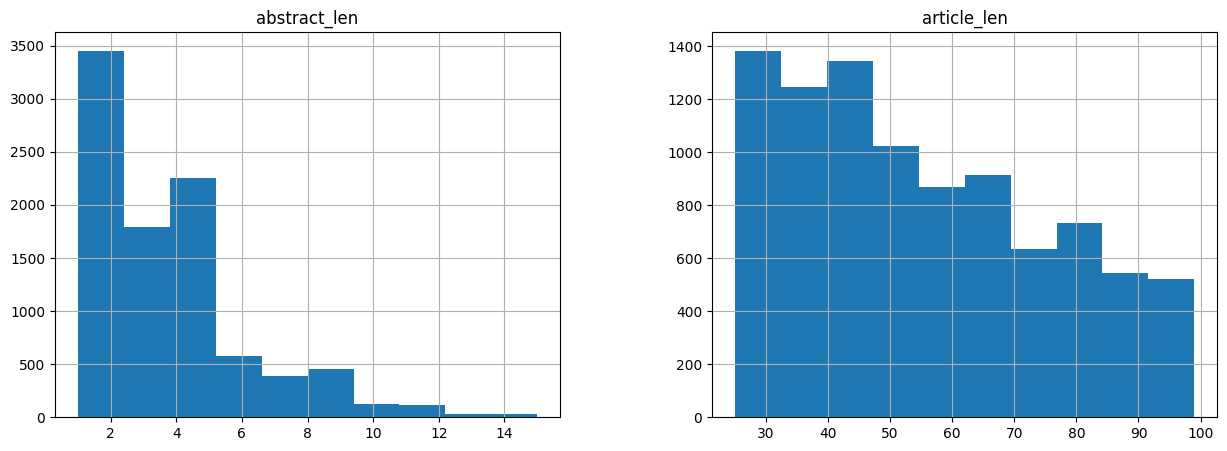

In [ ]:

data = pd.DataFrame([abstract_len, article_len]).T
data.columns = ['abstract_len', 'article_len']
data.hist(figsize=(15, 5))
data

In [ ]:
from datasets import concatenate_datasets, DatasetDict

english_dataset = DatasetDict()

for split in english_dataset.keys():
    english_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    english_dataset[split] = english_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(english_dataset)

KeyError: 'train'

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "LinhCT/mt5-small-finetuned-amazon-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

{'input_ids': [336, 259, 28387, 11807, 287, 62893, 295, 12507, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁', 'loved', '▁reading', '▁the', '▁Hung', 'er', '▁Games', '!', '</s>']

In [ ]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["email_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["subject_line"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
english_dataset

DatasetDict({
    train: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 9214
    })
    validation: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 1211
    })
    test: Dataset({
        features: ['email_body', 'subject_line'],
        num_rows: 1172
    })
})

In [ ]:
tokenized_datasets = english_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/9214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1211 [00:00<?, ? examples/s]

Map:   0%|          | 0/1172 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['email_body', 'subject_line', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 9214
    })
    validation: Dataset({
        features: ['email_body', 'subject_line', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1211
    })
    test: Dataset({
        features: ['email_body', 'subject_line', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1172
    })
})

In [ ]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=6cb2a44c77a3ddf96a86f8fff2f8b3089447c5cca633e36008ede4ec3f2e1ad7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [ ]:
scores["rouge1"].mid

Score(precision=0.86, recall=1.0, fmeasure=0.92)

In [ ]:
!pip install nltk

In [ ]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(english_dataset["train"][1]["email_body"]))

Phillip Good Morning!
I hope you had a wonderful Thanksgiving with your family and safe travels.
As per our meeting on Tuesday, please identify people you think will be good for the expert story roles.


In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["email_body"]]
    return metric.compute(predictions=summaries, references=dataset["subject_line"])

In [ ]:
import pandas as pd

score = evaluate_baseline(english_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 8.6, 'rouge2': 3.16, 'rougeL': 7.81, 'rougeLsum': 8.08}

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    english_dataset["train"].column_names
)

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9214
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1211
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1172
    })
})

In [ ]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[ 64666,    275, 165338,  32993,    261,    298, 138107,    339,    287,
          12282,  61061,   5124,    259,  92536,    260,    486,   4205,  11592,
            738,    390,   5897,    281,    259, 202730,    371,    260,    336,
           4016,   1689,    287,   4879,    264,    403, 237453,   3359,    259,
          44974,   3354,    609,   1070,   2101,  33763,    345,    455,    521,
            305,  12282,    260,    336,    898,  13003,    281,    287,  34566,
          11152,    304,    287,   9401,   1371,    336,    783,  11243,    285,
            609,    260,    259,   9560,    259, 128279,    305,   6559,    288,
            267,  12282,  61061,    261,  83648,  14644,   1682,  66808,    261,
           1716,    259,  81091,  18862,    261,    617, 120758,    259, 124843,
          41112,  23694,    260,  30956,  23075,  58076,  90789,    260,  21593,
          16907,      1],
        [139824,   8204,  71549,    309,    336,  10148,    521,   14

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,5.193100,3.789255,19.941600,8.788200,19.717500,19.694400
2,4.239100,3.603304,24.776200,11.462700,24.513200,24.534900
3,3.940100,3.508769,25.618000,11.875700,25.316000,25.378400
4,3.761700,3.460176,26.272100,11.806500,25.969300,26.051800
5,3.638100,3.443900,27.345900,12.668000,26.986200,27.052800
6,3.548000,3.431706,27.751000,12.771100,27.344500,27.391200
7,3.495600,3.434339,28.768500,13.183500,28.370200,28.438300
8,3.458900,3.424265,28.228200,13.007900,27.847600,27.937300


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=9216, training_loss=3.9091187119483948, metrics={'train_runtime': 4257.7023, 'train_samples_per_second': 17.313, 'train_steps_per_second': 2.165, 'total_flos': 1.009054550218752e+16, 'train_loss': 3.9091187119483948, 'epoch': 8.0})

In [ ]:
trainer.push_to_hub()


CommitInfo(commit_url='https://huggingface.co/LinhCT/mt5-small-finetuned-amazon-en-es-finetuned-amazon-en-es/commit/1b422615cc3b6eec83692bf06266c52112ad062c', commit_message='End of training', commit_description='', oid='1b422615cc3b6eec83692bf06266c52112ad062c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
trainer.evaluate()

{'eval_loss': 3.424264907836914,
 'eval_rouge1': 28.2282,
 'eval_rouge2': 13.0079,
 'eval_rougeL': 27.8476,
 'eval_rougeLsum': 27.9373,
 'eval_runtime': 31.4253,
 'eval_samples_per_second': 38.536,
 'eval_steps_per_second': 4.837,
 'epoch': 8.0}

In [ ]:
trainer.push_to_hub(repo_name="vn-en-mt5-small-summarization-small-dataset")

TypeError: Trainer.create_model_card() got an unexpected keyword argument 'repo_name'

In [ ]:
trainer.save_model('vn-en-mt5-small-summarization-small-dataset')

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

events.out.tfevents.1718076168.fa63a76e9f3e.378.0:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1718080584.fa63a76e9f3e.378.1:   0%|          | 0.00/562 [00:00<?, ?B/s]

In [ ]:
!zip vn-en-mt5-small-summarization-small-dataset.zip -r vn-en-mt5-small-summarization-small-dataset/

  adding: vn-en-mt5-small-summarization-small-dataset/ (stored 0%)
  adding: vn-en-mt5-small-summarization-small-dataset/special_tokens_map.json (deflated 73%)
  adding: vn-en-mt5-small-summarization-small-dataset/generation_config.json (deflated 29%)
  adding: vn-en-mt5-small-summarization-small-dataset/training_args.bin (deflated 51%)
  adding: vn-en-mt5-small-summarization-small-dataset/tokenizer_config.json (deflated 67%)
  adding: vn-en-mt5-small-summarization-small-dataset/tokenizer.json (deflated 76%)
  adding: vn-en-mt5-small-summarization-small-dataset/spiece.model (deflated 46%)
  adding: vn-en-mt5-small-summarization-small-dataset/config.json (deflated 47%)
  adding: vn-en-mt5-small-summarization-small-dataset/model.safetensors (deflated 23%)


In [ ]:
tokenized_datasets.set_format("torch")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "test-bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'lewtun/mt5-finetuned-amazon-en-es-accelerate'

In [ ]:
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the median ROUGE scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

Epoch 0: {'rouge1': 5.6351, 'rouge2': 1.1625, 'rougeL': 5.4866, 'rougeLsum': 5.5005}
Epoch 1: {'rouge1': 9.8646, 'rouge2': 3.4106, 'rougeL': 9.9439, 'rougeLsum': 9.9306}
Epoch 2: {'rouge1': 11.0872, 'rouge2': 3.3273, 'rougeL': 11.0508, 'rougeLsum': 10.9468}
Epoch 3: {'rouge1': 11.8587, 'rouge2': 4.8167, 'rougeL': 11.7986, 'rougeLsum': 11.7518}
Epoch 4: {'rouge1': 12.9842, 'rouge2': 5.5887, 'rougeL': 12.7546, 'rougeLsum': 12.7029}
Epoch 5: {'rouge1': 13.4628, 'rouge2': 6.4598, 'rougeL': 13.312, 'rougeLsum': 13.2913}
Epoch 6: {'rouge1': 12.9131, 'rouge2': 5.8914, 'rougeL': 12.6896, 'rougeLsum': 12.5701}
Epoch 7: {'rouge1': 13.3079, 'rouge2': 6.2994, 'rougeL': 13.1536, 'rougeLsum': 13.1194}
Epoch 8: {'rouge1': 13.96, 'rouge2': 6.5998, 'rougeL': 13.9123, 'rougeLsum': 13.7744}
Epoch 9: {'rouge1': 14.1192, 'rouge2': 7.0059, 'rougeL': 14.1172, 'rougeLsum': 13.9509}

In [ ]:
from transformers import pipeline

hub_model_id = "huggingface-course/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

In [ ]:
def print_summary(idx):
    review = books_dataset["test"][idx]["review_body"]
    title = books_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [ ]:
print_summary(100)

'>>> Review: Nothing special at all about this product... the book is too small and stiff and hard to write in. The huge sticker on the back doesn’t come off and looks super tacky. I would not purchase this again. I could have just bought a journal from the dollar store and it would be basically the same thing. It’s also really expensive for what it is.'

'>>> Title: Not impressed at all... buy something else'

'>>> Summary: Nothing special at all about this product'

In [ ]:
print_summary(0)

'>>> Review: Es una trilogia que se hace muy facil de leer. Me ha gustado, no me esperaba el final para nada'

'>>> Title: Buena literatura para adolescentes'

'>>> Summary: Muy facil de leer'